<a href="https://colab.research.google.com/github/ybing86-lang/MSSP6070/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind

In [3]:
from google.colab import files
uploaded = files.upload()

Saving HousingPrices.csv to HousingPrices.csv


In [4]:
df = pd.read_csv("HousingPrices.csv", encoding='latin-1', dtype={'CustomerAlternateKey': object})
df.head()

,Id,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,FullBath,TotalRooms,GarageCars,GarageArea,YrSold,SalePrice
0,1,65.0,8450.0,2Story,7,5,2003,856.0,Y,856,854,2,8,2,548,2008,208500
1,2,80.0,9600.0,1Story,6,8,1976,NaN,Y,1262,0,2,6,2,460,2007,181500
2,3,68.0,11250.0,2Story,7,5,2001,920.0,Y,920,866,2,6,2,608,2008,223500
3,4,60.0,9550.0,2Story,7,5,1915,NaN,Y,961,756,1,7,3,642,2006,140000
4,5,84.0,14260.0,2Story,8,5,2000,1145.0,Y,1145,1053,2,9,3,836,2008,250000


In [5]:
df.shape

(1460, 17)

In [6]:
df.describe().round(2)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,TotalRooms,GarageCars,GarageArea,YrSold,SalePrice
count,1460.00,1201.00,1341.00,1460.00,1460.00,1460.00,913.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.0
mean,730.50,70.05,10440.10,6.10,5.58,1971.27,1055.81,1162.63,346.99,1.57,6.52,1.77,472.98,2007.82,180921.2
std,421.61,24.28,10051.01,1.38,1.11,30.20,409.50,386.59,436.53,0.55,1.63,0.75,213.80,1.33,79442.5
min,1.00,21.00,1300.00,1.00,1.00,1872.00,0.00,334.00,0.00,0.00,2.00,0.00,0.00,2006.00,34900.0
25%,365.75,59.00,7500.00,5.00,5.00,1954.00,806.00,882.00,0.00,1.00,5.00,1.00,334.50,2007.00,129975.0
50%,730.50,69.00,9382.00,6.00,5.00,1973.00,996.00,1087.00,0.00,2.00,6.00,2.00,480.00,2008.00,163000.0
75%,1095.25,80.00,11500.00,7.00,6.00,2000.00,1286.00,1391.25,728.00,2.00,7.00,2.00,576.00,2009.00,214000.0
max,1460.00,313.00,215245.00,10.00,9.00,2010.00,3206.00,4692.00,2065.00,3.00,14.00,4.00,1418.00,2010.00,755000.0


In [7]:
price_mean = df['SalePrice'].mean()
price_mean

np.float64(180921.19589041095)

In [8]:
price_std = df['SalePrice'].std()
price_std

79442.50288288663

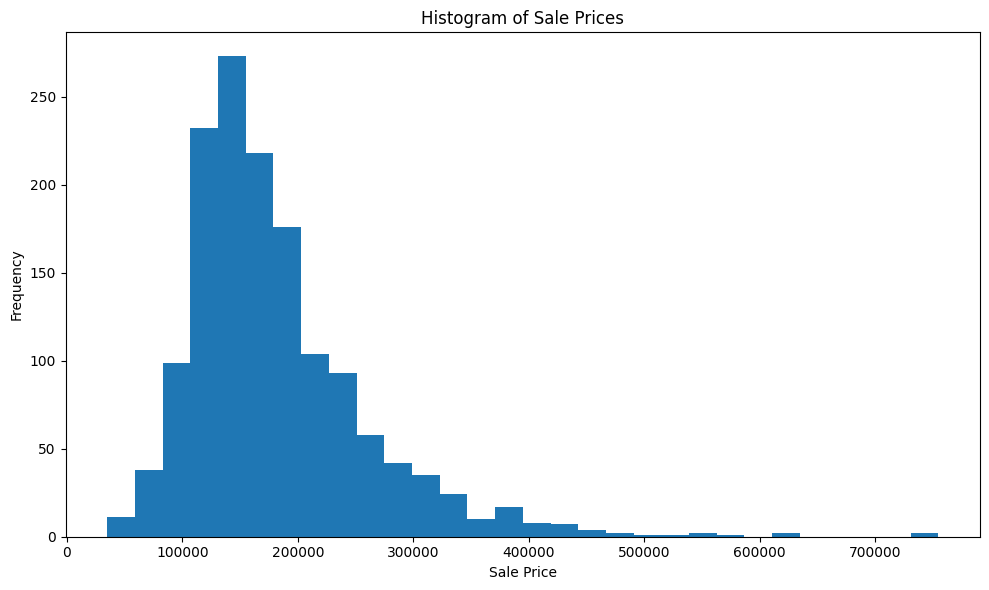

In [9]:
plt.figure(figsize=(10, 6))

plt.hist(df["SalePrice"].dropna(), bins=30)
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.title("Histogram of Sale Prices")

plt.tight_layout()
plt.show()

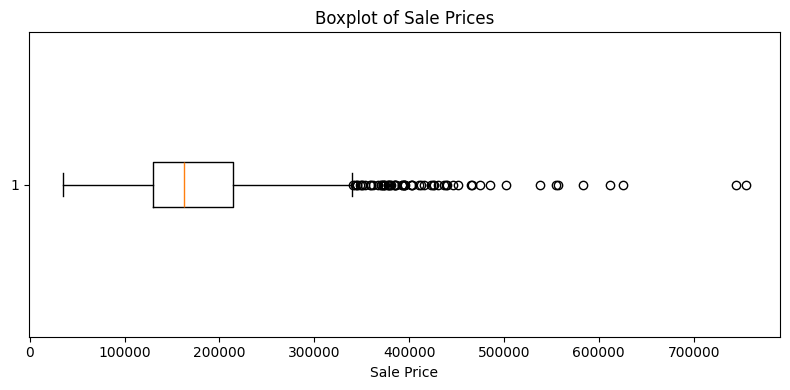

In [10]:
plt.figure(figsize=(8, 4))
plt.boxplot(df['SalePrice'], vert=False)
plt.xlabel('Sale Price')
plt.title('Boxplot of Sale Prices')
plt.tight_layout()
plt.show()

In [11]:
q1 = df['SalePrice'].quantile(0.25)
q3 = df['SalePrice'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr
[float(q1), float(q3), float(iqr), float(upper_bound)]

[129975.0, 214000.0, 84025.0, 340037.5]

In [12]:
df['is_outlier'] = df['SalePrice'] > upper_bound
df['is_outlier'].sum()

np.int64(61)

In [13]:
df['Segment_IQR'] = pd.cut(
    df['SalePrice'],
    bins=[-np.inf, q1, q3, upper_bound, np.inf],
    labels=['Low Budget', 'Mainstream', 'Upper Segment', 'Luxury Outliers']
)

df['Segment_IQR'].value_counts()

,count
Segment_IQR,
Mainstream,733
Low Budget,365
Upper Segment,301
Luxury Outliers,61


In [14]:
segment_price_stats = df.groupby('Segment_IQR')['SalePrice'].describe().round(2)
segment_price_stats

/tmp/ipython-input-3660023313.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_price_stats = df.groupby('Segment_IQR')['SalePrice'].describe().round(2)


,count,mean,std,min,25%,50%,75%,max
Segment_IQR,,,,,,,,
Low Budget,365.0,105831.59,19890.97,34900.0,93000.0,110000.0,121000.0,129900.0
Mainstream,733.0,165124.33,23345.83,130000.0,144000.0,163000.0,183500.0,214000.0
Upper Segment,301.0,260787.62,34654.17,214500.0,231500.0,253293.0,283463.0,340000.0
Luxury Outliers,61.0,425954.18,89557.26,341000.0,372500.0,394617.0,440000.0,755000.0


In [15]:
features = ['OverallQual', 'LotArea', 'TotalRooms', 'GarageCars']
segment_feature_stats = df.groupby('Segment_IQR')[features].mean().round(2)
segment_feature_stats

/tmp/ipython-input-1492798074.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_feature_stats = df.groupby('Segment_IQR')[features].mean().round(2)


,OverallQual,LotArea,TotalRooms,GarageCars
Segment_IQR,,,,
Low Budget,4.81,7674.09,5.57,1.12
Mainstream,5.98,9788.22,6.40,1.77
Upper Segment,7.43,13636.24,7.49,2.32
Luxury Outliers,8.75,19506.05,8.84,2.90


In [16]:
df[df['Segment_IQR'] == 'Luxury Outliers'].head()

,Id,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,FullBath,TotalRooms,GarageCars,GarageArea,YrSold,SalePrice,is_outlier,Segment_IQR
11,12,85.0,11924.0,2Story,9,5,2005,1175.0,Y,1182,1142,3,11,3,736,2006,345000,True,Luxury Outliers
53,54,68.0,50271.0,1Story,9,5,1981,1842.0,Y,1842,0,0,5,3,894,2006,385000,True,Luxury Outliers
58,59,66.0,13682.0,2Story,10,5,2006,NaN,Y,1426,1519,3,10,3,641,2006,438780,True,Luxury Outliers
112,113,77.0,NaN,2Story,7,5,2007,NaN,Y,1282,1414,2,10,3,792,2007,383970,True,Luxury Outliers
151,152,107.0,13891.0,1Story,8,5,2007,1710.0,Y,1710,0,2,6,3,866,2008,372402,True,Luxury Outliers


In [17]:
segment_feature_stats.loc[['Mainstream', 'Luxury Outliers']]
luxury_vs_mainstream_diff = (
    segment_feature_stats.loc['Luxury Outliers'] -
    segment_feature_stats.loc['Mainstream']
).round(2)

luxury_vs_mainstream_diff

,0
OverallQual,2.77
LotArea,9717.83
TotalRooms,2.44
GarageCars,1.13


In [18]:
corr = df[['SalePrice','OverallQual','LotArea','TotalRooms','GarageCars']].corr()
corr

,SalePrice,OverallQual,LotArea,TotalRooms,GarageCars
SalePrice,1.000000,0.790982,0.267748,0.533723,0.640409
OverallQual,0.790982,1.000000,0.108649,0.427452,0.600671
LotArea,0.267748,0.108649,1.000000,0.197113,0.157417
TotalRooms,0.533723,0.427452,0.197113,1.000000,0.362289
GarageCars,0.640409,0.600671,0.157417,0.362289,1.000000
